<a href="https://colab.research.google.com/github/mtszkw/garbage/blob/master/garbage2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up environment

#### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Copy data from Google Drive

In [2]:
    zip_path = '/content/drive/My Drive/Datasets/split-garbage-dataset.zip'

    !cp "{zip_path}" .

    !unzip -q split-garbage-dataset.zip

    !rm split-garbage-dataset.zip

    !ls

drive  sample_data  split-garbage-dataset


#### Install and import packages

In [ ]:
!pip install -U keras-tuner

In [4]:
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import kerastuner as kt
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

BASE_DIR   = './split-garbage-dataset/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data

#### Load image datasets

In [15]:
seed = 1234
batch_size = 128

dataset_config = {
    'label_mode': 'categorical',
    'color_mode': 'rgb',
    'batch_size': batch_size,
    'shuffle': True,
    'seed': seed,
}

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(BASE_DIR, 'train'),
    **dataset_config
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(BASE_DIR, 'valid'),
    **dataset_config
)

Found 1768 files belonging to 6 classes.
Found 328 files belonging to 6 classes.


#### Display sample images

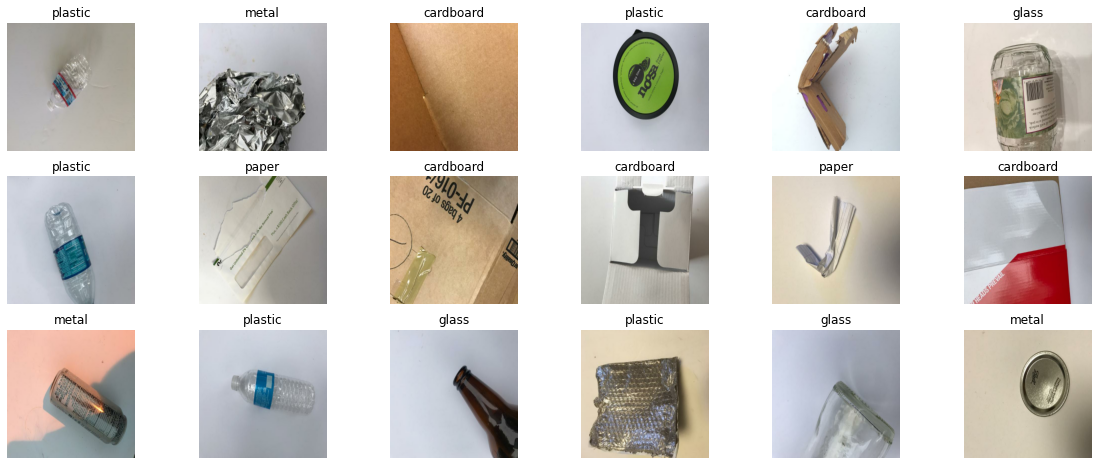

In [16]:
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(20, 8))
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

for images, labels in train_ds.take(1):
    axs = axs.flatten()
    for i in range(18):
        axs[i].imshow(images[i].numpy().astype('uint8'))
        axs[i].set_title(class_names[np.argmax(labels.numpy()[i])])
        axs[i].axis('off')

plt.show();

#### Normalize images

In [17]:
# def process(image,label):
#     image = tf.cast(image / 255. ,tf.float32)
#     return image, label

# train_ds = train_ds.map(process)
# valid_ds = valid_ds.map(process)

# for images, labels in train_ds.take(1):
#     print(images.shape)
#     print(images[0])

#### Class weights

In [18]:
train_classes = np.argmax(np.concatenate([y for x, y in train_ds], axis=0), axis=1)

class_weights = class_weight.compute_class_weight(
    'balanced', np.unique(train_classes), train_classes)

class_weights = {i : class_weights[i] for i in range(6)}

class_weights

{0: 1.0267131242740999,
 1: 0.832391713747646,
 2: 1.0303030303030303,
 3: 0.7311827956989247,
 4: 0.8491834774255523,
 5: 3.238095238095238}

## Define baseline models

In [19]:
class BaselineModel():

    def __init__(self, num_classes):
        self.num_classes = num_classes

    def return_backbone(self, backbone):
        if backbone == 'resnet50':
            return tf.keras.applications.ResNet50
        elif backbone == 'vgg16':
            return tf.keras.applications.VGG16

    def build(self, backbone: str):
        base_model = self.return_backbone(backbone)(weights='imagenet', include_top=False)

        x = base_model.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(rate=.3)(x)
        x = tf.keras.layers.Dense(1024, activation='relu')(x)
        x = tf.keras.layers.Dropout(rate=.3)(x)
        x = tf.keras.layers.Dense(512, activation='relu')(x)
        predictions = tf.keras.layers.Dense(6, activation='softmax')(x)

        model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

        for i in range(len(base_model.layers)-1):
            base_model.layers[i].trainable = False

        model.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.SGD(),
                    metrics=['accuracy'])
            
        return model


#### Train VGG16 baseline

In [20]:
base_vgg16 = BaselineModel(num_classes=6).build(backbone='vgg16')
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              mode='min',
                                              patience=5,
                                              restore_best_weights=True)]

hist_vgg16 = base_vgg16.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=0)

#### Train ResNet50 basline

In [21]:
base_rn50 = BaselineModel(num_classes=6).build(backbone='resnet50')
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              mode='min',
                                              patience=5,
                                              restore_best_weights=True)]

hist_rn50 = base_rn50.fit(
    train_ds,
    epochs=50,
    validation_data=valid_ds,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=0)

## Optimizable model (kt.HyperModel)

In [22]:
class MyHyperModel(kt.HyperModel):

    def __init__(self, num_classes):
        self.num_classes = num_classes

    def return_backbone(self, backbone):
        if backbone == 'resnet50':
            return tf.keras.applications.ResNet50
        elif backbone == 'vgg16':
            return tf.keras.applications.VGG16

    def return_optimizer(self, opt, init_lr):
        if  opt == 'adam':
            return tf.keras.optimizers.Adam(lr=init_lr)
        elif opt == 'sgd':
            return tf.keras.optimizers.SGD(lr=init_lr)

    def build(self, hp):
        backbone = hp.Choice('backbone', values=['resnet50', 'vgg16'])
        
        base_model = self.return_backbone(backbone)(weights='imagenet', include_top=False)

        lr = hp.Float('lr', 1e-2, 1e-4)
        dropout_1 = hp.Float('dropout_1', 0.1, 0.4)
        dropout_2 = hp.Float('dropout_2', 0.1, 0.2)
        dense_units = hp.Int('units', min_value=128, max_value=512, step=64)
        opt = hp.Choice('optimizer', values=['adam', 'sgd'])

        x = base_model.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(rate=dropout_1)(x)
        x = tf.keras.layers.Dense(1024, activation='relu')(x)
        x = tf.keras.layers.Dropout(rate=dropout_2)(x)
        x = tf.keras.layers.Dense(units=dense_units, activation='relu')(x)
        predictions = tf.keras.layers.Dense(6, activation='softmax')(x)

        model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

        for i in range(len(base_model.layers)-1):
            base_model.layers[i].trainable = False

        model.compile(loss='categorical_crossentropy',
                    optimizer=self.return_optimizer(opt, lr),
                    metrics=['accuracy'])
            
        return model


#### Search space summary

In [23]:
hypermodel = MyHyperModel(num_classes=6)
tuner = kt.RandomSearch(hypermodel, objective='val_loss', max_trials=30, overwrite=True)

#### Run search with Keras Tuner

In [24]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              mode='min',
                                              patience=5,
                                              restore_best_weights=True)]

tuner.search(train_ds, epochs=15, validation_data=valid_ds, callbacks=callbacks, class_weight=class_weights, verbose=0)

INFO:tensorflow:Oracle triggered exit


#### Get best hyperparameters

In [25]:
best_hp = tuner.get_best_hyperparameters()[0]

for hp in ['backbone', 'dropout_1', 'dropout_2', 'lr', 'units', 'optimizer']:
    print(f'{hp} = {best_hp.get(hp)}')

backbone = resnet50
dropout_1 = 0.39842521567715183
dropout_2 = 0.1684175797330582
lr = 0.0011525735271774445
units = 256
optimizer = adam


In [26]:
models = tuner.get_best_models(num_models=2)

valid_loss, valid_acc = models[0].evaluate(valid_ds)
print(f'Loss = {valid_loss}, accuracy = {valid_acc} for validation set (best model)')

valid_loss, valid_acc = models[1].evaluate(valid_ds)
print(f'Loss = {valid_loss}, accuracy = {valid_acc} for validation set (2nd best model)')

3/3 [==============================] - 2s 523ms/step - loss: 0.2569 - accuracy: 0.9055
Loss = 0.25694894790649414, accuracy = 0.9054877758026123 for validation set (best model)
3/3 [==============================] - 2s 524ms/step - loss: 0.2723 - accuracy: 0.9207
Loss = 0.27226653695106506, accuracy = 0.9207317233085632 for validation set (2nd best model)


In [27]:
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)

In [28]:
# model.summary()

## Training (optimized model)

In [29]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              mode='min',
                                              patience=5,
                                              restore_best_weights=True)]

history = model.fit(
    train_ds, epochs=50,
    validation_data=valid_ds,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=2)

Epoch 1/50
14/14 - 18s - loss: 1.5733 - accuracy: 0.4887 - val_loss: 0.8729 - val_accuracy: 0.6341
Epoch 2/50
14/14 - 18s - loss: 0.6805 - accuracy: 0.7387 - val_loss: 0.6386 - val_accuracy: 0.7622
Epoch 3/50
14/14 - 18s - loss: 0.5531 - accuracy: 0.8003 - val_loss: 0.4837 - val_accuracy: 0.8262
Epoch 4/50
14/14 - 18s - loss: 0.4219 - accuracy: 0.8405 - val_loss: 0.3947 - val_accuracy: 0.8659
Epoch 5/50
14/14 - 17s - loss: 0.3307 - accuracy: 0.8727 - val_loss: 0.4305 - val_accuracy: 0.8262
Epoch 6/50
14/14 - 17s - loss: 0.2911 - accuracy: 0.8903 - val_loss: 0.4227 - val_accuracy: 0.8476
Epoch 7/50
14/14 - 18s - loss: 0.2488 - accuracy: 0.9061 - val_loss: 0.3064 - val_accuracy: 0.8963
Epoch 8/50
14/14 - 17s - loss: 0.2138 - accuracy: 0.9123 - val_loss: 0.3977 - val_accuracy: 0.8476
Epoch 9/50
14/14 - 17s - loss: 0.2192 - accuracy: 0.9152 - val_loss: 0.3465 - val_accuracy: 0.8811
Epoch 10/50
14/14 - 17s - loss: 0.1968 - accuracy: 0.9191 - val_loss: 0.3198 - val_accuracy: 0.8841
Epoch 11/

#### Display history

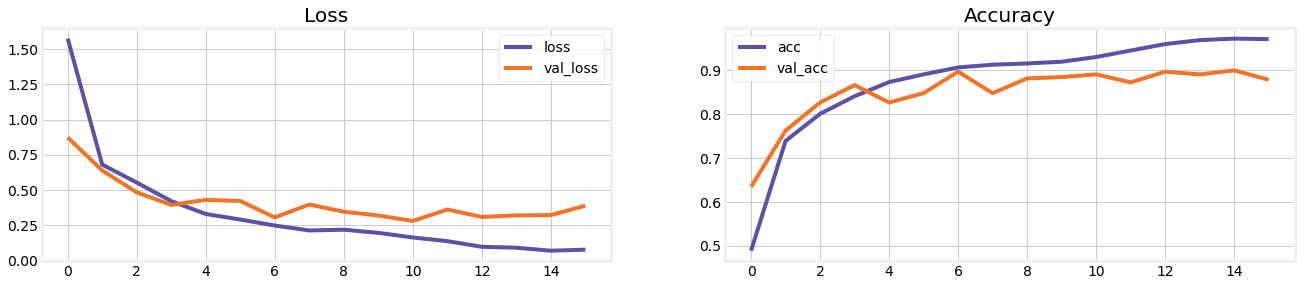

In [30]:
# Set the default color cycle
mpl.style.use('fivethirtyeight')
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#5a52a4', '#f27427', '#2FA798']) 

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val_loss')
axs[0].set_title('Loss')
axs[0].legend()


axs[1].plot(history.history['accuracy'], label='acc')
axs[1].plot(history.history['val_accuracy'], label='val_acc')
axs[1].set_title('Accuracy')
axs[1].legend()

plt.legend();
plt.show();

#### Evaluate on test set

In [35]:
test_dataset_config = {
    'label_mode': 'categorical',
    'color_mode': 'rgb',
    'batch_size': 1,
    'shuffle': False,
    'seed': seed,
}

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(BASE_DIR, 'test'),
    **test_dataset_config )

test_loss, test_acc = base_vgg16.evaluate(test_ds, batch_size=1)
print(f'[Baseline VGG16] Loss = {test_loss}, accuracy = {test_acc} for test set')

test_loss, test_acc = base_rn50.evaluate(test_ds, batch_size=1)
print(f'[Baseline ResNet50] Loss = {test_loss}, accuracy = {test_acc} for test set')

test_loss, test_acc = model.evaluate(test_ds, batch_size=1)
print(f'[HyperMode] Loss = {test_loss}, accuracy = {test_acc} for test set')

Found 431 files belonging to 6 classes.
431/431 [==============================] - 13s 30ms/step - loss: 0.4932 - accuracy: 0.8237
[Baseline VGG16] Loss = 0.4932003617286682, accuracy = 0.8236659169197083 for test set
431/431 [==============================] - 13s 29ms/step - loss: 0.3336 - accuracy: 0.8724
[Baseline ResNet50] Loss = 0.33364376425743103, accuracy = 0.8723897933959961 for test set
431/431 [==============================] - 12s 29ms/step - loss: 0.2779 - accuracy: 0.9188
[HyperMode] Loss = 0.2778874635696411, accuracy = 0.9187934994697571 for test set


#### Classification report

In [32]:
y_pred = np.argmax(model.predict(test_ds, batch_size=1), axis=1)
y_test = np.argmax(np.concatenate([y for x, y in test_ds], axis=0), axis=1)

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   cardboard       0.96      0.93      0.94        70
       glass       0.94      0.93      0.93        82
       metal       0.89      0.93      0.91        68
       paper       0.92      0.93      0.92       108
     plastic       0.90      0.88      0.89        74
       trash       0.90      0.93      0.92        29

    accuracy                           0.92       431
   macro avg       0.92      0.92      0.92       431
weighted avg       0.92      0.92      0.92       431



#### Confusion matrix

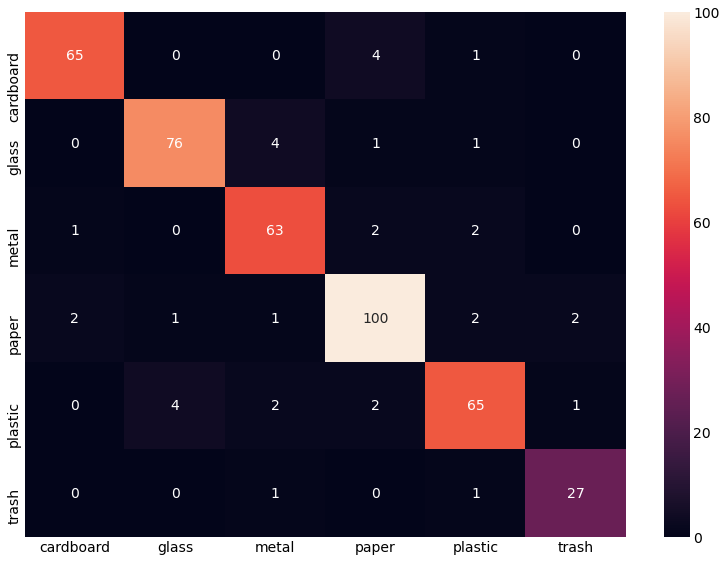

In [33]:
cm = confusion_matrix(y_test, y_pred)

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(cm, ax=ax, annot=True, fmt="d",
            xticklabels=test_ds.class_names, yticklabels=class_names);

## Compare baseline and opt. model

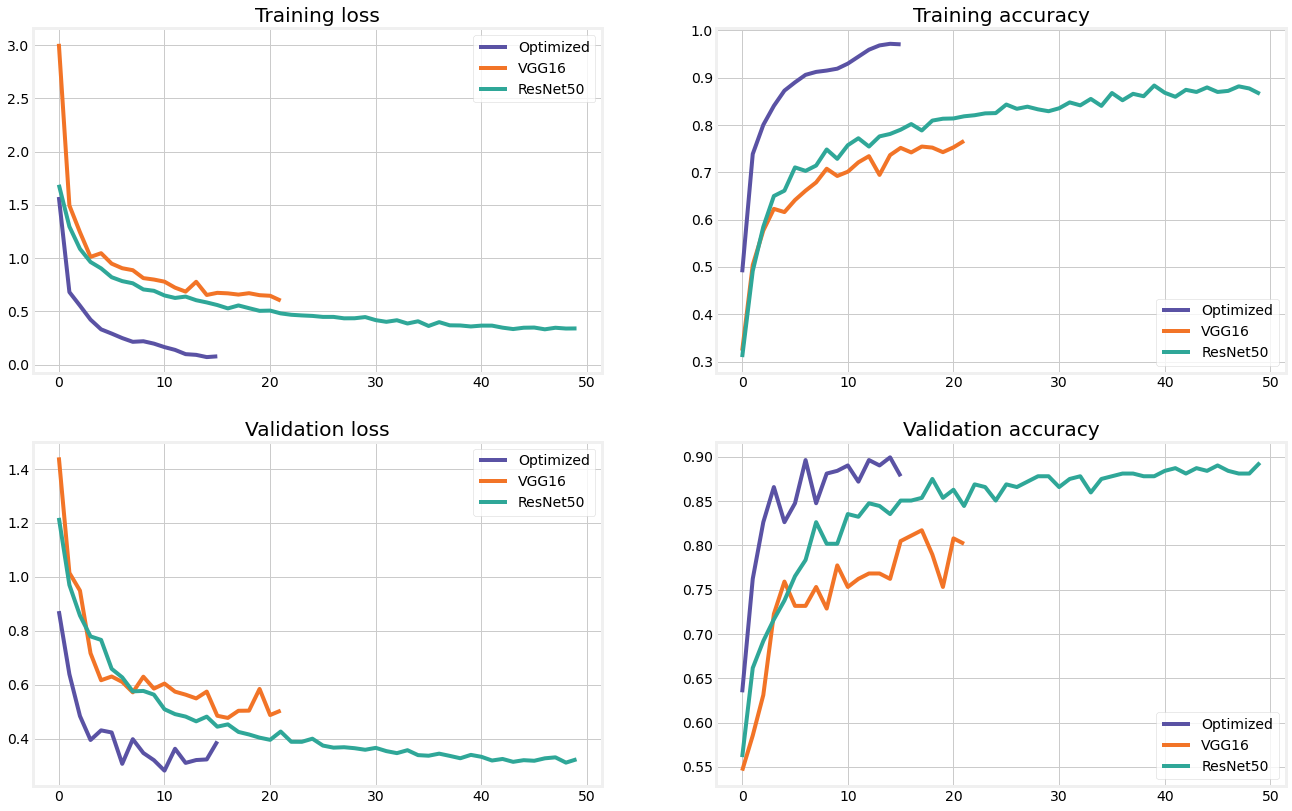

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 13))

axs[0][0].plot(history.history['loss'], label='Optimized')
axs[0][0].plot(hist_vgg16.history['loss'], label='VGG16')
axs[0][0].plot(hist_rn50.history['loss'], label='ResNet50')
axs[0][0].set_title('Training loss')
axs[0][0].legend()

axs[0][1].plot(history.history['accuracy'], label='Optimized')
axs[0][1].plot(hist_vgg16.history['accuracy'], label='VGG16')
axs[0][1].plot(hist_rn50.history['accuracy'], label='ResNet50')
axs[0][1].set_title('Training accuracy')
axs[0][1].legend()


axs[1][0].plot(history.history['val_loss'], label='Optimized')
axs[1][0].plot(hist_vgg16.history['val_loss'], label='VGG16')
axs[1][0].plot(hist_rn50.history['val_loss'], label='ResNet50')
axs[1][0].set_title('Validation loss')
axs[1][0].legend()

axs[1][1].plot(history.history['val_accuracy'], label='Optimized')
axs[1][1].plot(hist_vgg16.history['val_accuracy'], label='VGG16')
axs[1][1].plot(hist_rn50.history['val_accuracy'], label='ResNet50')
axs[1][1].set_title('Validation accuracy')
axs[1][1].legend()

plt.legend();
plt.show();